In [1]:
!pip install --upgrade transformers==4.45.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [2]:
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [3]:
from transformers import VisionEncoderDecoderModel
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import TrOCRProcessor
from PIL import Image


import matplotlib.pyplot as plt
from matplotlib import font_manager as fm


import os
import random

import pandas as pd
import numpy as np

2025-06-21 14:34:19.123125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750516459.323689      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750516459.383964      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
root_directory = '/kaggle/input/hindi-words-dataset/HindiSeg/'
train_df = pd.read_csv('/kaggle/input/hindi-dataset-label-updated/train_extracted_files.csv')
test_df = pd.read_csv('/kaggle/input/hindi-dataset-label-updated/test_extracted_files.csv')
val_df = pd.read_csv('/kaggle/input/hindi-dataset-label-updated/val_extracted_files.csv')

In [5]:
train_df.head(3)

,0,file_name,text
0,0,HindiSeg/train/8/251/21.jpg,केंद्रों
1,1,HindiSeg/train/10/207/8.jpg,पॉवर
2,2,HindiSeg/train/10/31/19.jpg,तरक्की


In [6]:
val_df.head(3)

,Unnamed: 0,file_name,text
0,0,HindiSeg/val/3/165/18.jpg,शरावती
1,1,HindiSeg/val/12/43/27.jpg,जोख
2,2,HindiSeg/val/12/1/36.jpg,बहादुर


In [7]:
test_df.head(3)

,Unnamed: 0,file_name,text
0,0,HindiSeg/test/9/2/22.jpg,अनाथों
1,1,HindiSeg/test/11/2/24.jpg,इज्ज्त
2,2,HindiSeg/test/11/55/29.jpg,देखना


In [8]:
print(test_df.shape, val_df.shape, train_df.shape)

(12869, 3) (12708, 3) (69853, 3)


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        
        # Prepare image (resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        image = self.preprocess_image(image)
        # Convert the image to pixel values
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids

       
        # Ensure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

    def preprocess_image(self, image):
        # Resize while maintaining aspect ratio
        target_size = (224, 224)
        original_size = image.size

        # Calculate the new size while maintaining aspect ratio
        aspect_ratio = original_size[0] / original_size[1]
        if aspect_ratio > 1:  # Width is greater than height
            new_width = target_size[0]
            new_height = int(target_size[0] / aspect_ratio)
        else:  # Height is greater than width
            new_height = target_size[1]
            new_width = int(target_size[1] * aspect_ratio)

        # Resize the image
        resized_img = image.resize((new_width, new_height))

        # Calculate padding values
        padding_width = target_size[0] - new_width
        padding_height = target_size[1] - new_height

        # Apply padding to center the resized image
        pad_left = padding_width // 2
        pad_top = padding_height // 2
        pad_image = Image.new('RGB', target_size, (255, 255, 255))  # White background
        pad_image.paste(resized_img, (pad_left, pad_top))

        return pad_image

In [10]:
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor, PreTrainedTokenizerFast
from transformers import VisionEncoderDecoderModel
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

encode = 'google/vit-base-patch16-224-in21k'
decode = "Rajan/nepbertaTorch"

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
# tokenizer = RobertaTokenizer.from_pretrained(decode)
tokenizer = AutoTokenizer.from_pretrained("Rajan/nepbertaTorch")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/547k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [11]:
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir=root_directory ,
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=root_directory,
                           df=val_df,
                           processor=processor)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
print(processor.tokenizer.pad_token_id)
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 32
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:47: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at Rajan/nepbertaTorch and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossattention.self.key.bias', 'encoder.layer.0.crossattention.self.key.weight', 'encoder.layer.0.crossattention.self.query.bias', 'encoder.layer.0.crossattention.self.query.weight', 'encoder.layer.0.crossattention.self.value.bias', 'encoder.layer.0.crossattention.self.value.weight', 'encoder.layer.1.crossattention.output.LayerNorm.bias', 'encoder.layer.1.crossattention.output.LayerNorm.weight', 'encod

1


In [12]:

def filter_special_tokens(decoded_strs):
    """Filter out empty strings and remove '##' prefixes from tokens."""
    filtered_strs = []
    for s in decoded_strs:
        if s:  # Only include non-empty strings
            filtered = s.replace("##", "")  # Remove subword prefix
            filtered_strs.append(filtered.strip())  # Strip whitespace
    return filtered_strs

def join_tokens(filtered_tokens):
    """Join filtered tokens into a single string or word."""
    return ''.join(filtered_tokens)  # Adjust delimiter if necessary

def calculate_cer(reference, prediction):
    """Calculate Character Error Rate (CER) between reference and prediction."""
    # Convert strings to lists of characters
    ref_chars = list(reference)
    pred_chars = list(prediction)

    # Create a distance matrix
    dp = np.zeros((len(ref_chars) + 1, len(pred_chars) + 1))

    # Initialize the distance matrix
    for i in range(len(ref_chars) + 1):
        dp[i][0] = i  # Deleting all characters from reference
    for j in range(len(pred_chars) + 1):
        dp[0][j] = j  # Inserting all characters to match prediction

    # Populate the distance matrix
    for i in range(1, len(ref_chars) + 1):
        for j in range(1, len(pred_chars) + 1):
            cost = 0 if ref_chars[i - 1] == pred_chars[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,      # Deletion
                           dp[i][j - 1] + 1,      # Insertion
                           dp[i - 1][j - 1] + cost)  # Substitution

    # The bottom-right cell contains the edit distance (CER)
    cer = dp[len(ref_chars)][len(pred_chars)]
    
    # Calculate the Character Error Rate
    cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length
    return cer_rate


def compute_metrics(pred):
    """Compute metrics including CER based on predictions and labels."""
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    # Initialize lists to hold CER results
    cer_list = []

    # Process each prediction and label pair
    for pred, label in zip(pred_str, label_str):
        # Filter special tokens and subword prefixes
        pred_filtered = filter_special_tokens([pred])
        label_filtered = filter_special_tokens([label])

        # Join tokens into words
        pred_joined = join_tokens(pred_filtered)
        label_joined = join_tokens(label_filtered)
        
        # Calculate CER for the individual example
        cer = calculate_cer(label_joined, pred_joined)
        cer_list.append(cer)
    print('p',pred_str[1:40])
    print('l',label_str[1:40])

    # Average CER across the batch
    avg_cer = sum(cer_list) / len(cer_list) if cer_list else 0
    return {"cer": avg_cer}

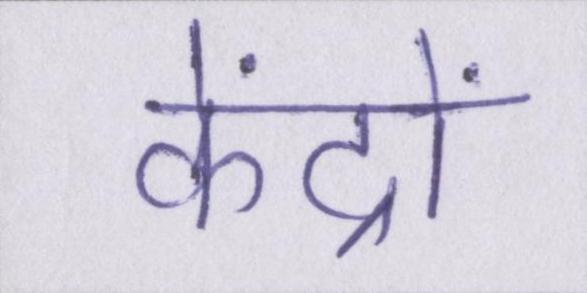

In [13]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [14]:
from evaluate import load

# cer_metric = load("cer")
wer_metric = load("wer")

In [15]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: udayagrawal2023 (uday29) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments





# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",  # Evaluate every few steps
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir='/kaggle/working/',  # Output directory to save models
    save_total_limit=4,  # Limit the number of saved checkpoints
    logging_steps=100,  # Log every 2 steps
    save_steps=4000,  # Save model every 100 steps
    eval_steps=4000,  # Evaluate every 100 steps
    save_strategy="steps",  # Save based on steps
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="cer",  # Use CER to evaluate the best model
    greater_is_better=False,  # Lower CER is better, hence set to False
    num_train_epochs = 4,
    report_to="all",    
    disable_tqdm = False
)

In [17]:
from transformers import default_data_collator


# Instantiate the trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,  # Ensure the correct tokenizer is used
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [18]:
from transformers.optimization import get_cosine_schedule_with_warmup

# Initialize the optimizer
optimizer = torch.optim.Adam(lr=5e-5, params=model.parameters())
total_steps = trainer.get_train_dataloader().__len__() * training_args.num_train_epochs
warmup_steps = int(0.05 * total_steps)  # 5% of total training steps


# Set the scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,


    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
trainer.lr_scheduler = scheduler

print("total steps",total_steps)
print("Train begins now")

total steps 34928
Train begins now


In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
4000,2.297100,2.679467,0.764627
8000,0.976900,1.783208,0.394412
12000,0.564000,2.259013,0.298288
16000,0.374600,2.216550,nan
20000,0.252300,2.749928,nan
24000,0.195400,2.462816,nan
28000,0.138800,2.918602,nan
32000,0.121500,2.789918,nan


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


p ['सरवोच', 'करतदर', 'उतपादर', 'यॉ', 'उतप', 'परतिबधित', 'उतततव', 'उततत - बहततर', 'या', 'करो', 'उतत', 'टरडिग', 'जायव', 'करतव', 'परतिबधिती', 'विशवविदयालय', 'लौटता ।', 'पहना', 'परतिबधति', 'कभी', 'गदो', 'दध', 'उततततर', 'पकषिक', 'पहचना', 'पडी', 'उतपीडन', 'उतपादा', 'सरक', 'परतिबधित', 'उततत ।', 'दड', 'हसत', 'उतत', 'उतपीडन', 'सरजी', 'या ।', 'परवत', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2612: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 32, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


p ['जोगश', 'बदहवार', 'वकवास', 'भा', 'कौच', 'मनःशानती', 'अरदव', 'शरा - खदान', 'गा', 'पछो', 'शाल', 'सिदधिदायक', 'गावय', 'अबान', 'मोजिली', 'आरयसमाज', 'मिलगा ।', 'कमरा', 'अभिरदिवसी', 'मतरी', 'शौो', 'छल', 'तातारपर', 'छिपाकर', 'रगनगर', 'सीही', 'आरयसटिट', 'यतरणापरण', 'शक', 'सिचित', 'मदबबत', 'टकड', 'इसोस', 'पढत', 'आतमहन', 'सौपी', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


p ['जोख', 'दहरादर', 'बकवास', 'मा', 'कोच', 'जनटीकली', 'परफलल', 'अरथ - ख - खद', 'जाग', 'परदशो', 'शहाद', 'सटरिपटीज', 'गपत', 'अचल', 'मडिकली', 'सामजसय', 'मिलगा ।', 'कमना', 'अनियतरित', 'मची', 'शौ', 'छ', 'तातपर', 'हिससा', 'खनान', 'सीडी', 'आरयटिव', 'रपय', 'शकर', 'रियायत', 'मधख', 'कड', 'इनस', 'पढत', 'आतमजञान', 'सपरी', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_35/1924302920.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length


p ['जोख', 'बहादर', 'बकवास', 'खा', 'कथ', 'जनटीकली', 'परफलल', 'आदर - भाव', 'गा', 'पदो', 'राषटर', 'सिदधिदायक', 'गयारह', 'अववल', 'मडिकली', 'सामजसय', 'मिलगा ।', 'कमना', 'अनियतरिक', 'मची', 'रौ', 'छ', 'तातारपर', 'छिपाकर', 'खानदान', 'डीएसपी', 'आरआईटी', 'वयाकरण', 'शकर', 'सथिति', 'मछत', 'कड', 'इषटस', 'पढत', 'सामहकन', 'सपारी', 'जा ।', 'परात', 'यट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3033: RuntimeWarning: invalid value encountered in less
  or operator(metric_value, self.state.best_metric)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_35/1924302920.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length


p ['ओख', '', 'बकवास', 'मा', 'कप', 'मतरनी', 'अपरवल', 'आरएसएस', 'गा', 'पकषो', 'राषटर', 'सटाफिज', 'गायव', 'अकल', 'मडीकली', 'हासयासपद', 'मिलगा ।', 'कगना', 'अनौपचारिक', 'मची', 'शौ', '', 'तासरपर', 'हिसातर', 'नारापन', 'सीडीओ', 'आशचरयचकित', 'वयाकरण', 'शकर', 'सथिति', 'मछबत', 'कड', 'इचस', 'पढत', 'आतमहन', 'सोची', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3033: RuntimeWarning: invalid value encountered in less
  or operator(metric_value, self.state.best_metric)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_35/1924302920.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length


p ['जोख', 'दहराटर', 'बकवास', 'तय', 'कोच', 'एनटीपीसी', 'अपरवल', 'आर - गपत', 'गा', 'पकषडो', 'शतल', 'सटरिपटीज', 'गावय', 'अववल', 'मडिकली', 'सवालसास', 'मिलगा ।', 'कगना', 'एनटीपीसिव', 'मची', 'शो', 'छ', 'तातारपर', 'हासयास', 'सनान', 'सीडी', 'आरटटीन', 'फायरफॉकस', 'शकर', 'सथिति', 'कषबध', 'कड', 'डरसस', 'पढत', 'मातभाषा', 'सोची', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3033: RuntimeWarning: invalid value encountered in less
  or operator(metric_value, self.state.best_metric)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_35/1924302920.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length


p ['जोख', 'दहरा', 'बकवास', 'का', 'कप', 'जनटीकली', 'अकषबल', 'उतार - चढाव', 'गा', 'पडो', 'राषटर', 'सटरिपटीज', 'गावयव', 'अववल', 'मडिकली', 'हासयासपद', 'मिलगा ।', 'मगना', 'एनीमिजम', 'मची', 'शौ', 'छ', 'शतारपर', 'हासय', 'सनापन', 'सटरी', 'आउटफिट', 'कपाउ', 'शकर', 'सथिति', 'मशबत', 'कप', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3033: RuntimeWarning: invalid value encountered in less
  or operator(metric_value, self.state.best_metric)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


p ['शोर', 'दाददार', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अगर', 'उतार - चढाव', 'गा', 'पडो', 'शल', 'सटरिपटीज', 'गपत', 'अकल', 'मडिकली', 'हासयासपद', 'मिलगा ।', 'मगना', 'सनीबोगरीब', 'मयी', 'शौ', 'छ', 'तातारपर', 'हिमायत', '', 'सीडी', 'आरआईसीट', 'टया', 'शकर', 'सथिति', 'मखयतः', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']
l ['जोख', 'बहादर', 'बकवास', 'मॉ', 'कोच', 'जनटीकली', 'अपरवल', 'उतार - चढाव', 'गा', 'पडो', 'शाल', 'सटरिपटीज', 'गायब', 'अववल', 'मडिकली', 'खासमखास', 'मिलगा ।', 'कगना', 'अजीबोगरीब', 'मची', 'शो', 'छ', 'तातारपर', 'हिमायत', 'खानपान', 'सीडी', 'आउटफिट', 'वयाकरण', 'शकर', 'सथिति', 'महबबत', 'कड', 'डरसस', 'पढत', 'आतमहनन', 'सोची', 'जा ।', 'परात', 'पषट']


/tmp/ipykernel_35/1924302920.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cer_rate = cer / max(len(ref_chars), len(pred_chars))  # Normalized by max length
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3033: RuntimeWarning: invalid value encountered in less
  or operator(metric_value, self.state.best_metric)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=34928, training_loss=0.7787681436571461, metrics={'train_runtime': 31522.0892, 'train_samples_per_second': 8.864, 'train_steps_per_second': 1.108, 'total_flos': 5.058090619487075e+19, 'train_loss': 0.7787681436571461, 'epoch': 4.0})

In [20]:
# Define the model save path
model_save_path = "/kaggle/working/model"

# Create the directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the model
model.save_pretrained(model_save_path)

In [28]:
!ls /kaggle/working



checkpoint-12000  checkpoint-32000  model  wandb
checkpoint-28000  checkpoint-34928  runs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
processor.save_pretrained("/kaggle/working/checkpoint-34928")

[]

In [29]:
import shutil

# Replace with your folder name
folder_path = "/kaggle/working/checkpoint-34928"

# Output zip file path (without .zip extension)
zip_path = "/kaggle/working/checkpoint-34928"

# Create zip
shutil.make_archive(zip_path, 'zip', folder_path)

'/kaggle/working/checkpoint-34928.zip'

In [31]:
import torch
from PIL import Image

# Put model in eval mode and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Number of samples to test
num_samples = 10  # Change this as needed

for idx in range(num_samples):
    # Get file path and label
    row = test_df.iloc[idx]
    image_path = root_directory + row['file_name']
    ground_truth = row['text']

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image = IAMDataset.preprocess_image(None, image)  # Static call
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=32, num_beams=4)

    # Decode prediction
    prediction = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    prediction = prediction.replace("##", "").strip()

    # Print output
    print(f"\n🖼 Image: {row['file_name']}")
    print(f"✅ Ground Truth: {ground_truth}")
    print(f"🔮 Prediction  : {prediction}")


🖼 Image: HindiSeg/test/9/2/22.jpg
✅ Ground Truth: अनाथों
🔮 Prediction  : अनाओ

🖼 Image: HindiSeg/test/11/2/24.jpg
✅ Ground Truth: इज्ज्त
🔮 Prediction  : इजञ

🖼 Image: HindiSeg/test/11/55/29.jpg
✅ Ground Truth: देखना
🔮 Prediction  : दखना

🖼 Image: HindiSeg/test/11/23/7.jpg
✅ Ground Truth: मृतका
🔮 Prediction  : मनका ।

🖼 Image: HindiSeg/test/6/59/9.jpg
✅ Ground Truth: ऊर्ध्वगामी
🔮 Prediction  : अरदशी

🖼 Image: HindiSeg/test/9/88/34.jpg
✅ Ground Truth: छक्कों
🔮 Prediction  : धकको

🖼 Image: HindiSeg/test/6/11/28.jpg
✅ Ground Truth: प्रतिभावान
🔮 Prediction  : परतिभावान

🖼 Image: HindiSeg/test/9/95/15.jpg
✅ Ground Truth: पदार्थ
🔮 Prediction  : परारथ

🖼 Image: HindiSeg/test/6/36/30.jpg
✅ Ground Truth: उबालें
🔮 Prediction  : उबालो

🖼 Image: HindiSeg/test/9/140/36.jpg
✅ Ground Truth: बसर
🔮 Prediction  : वसर


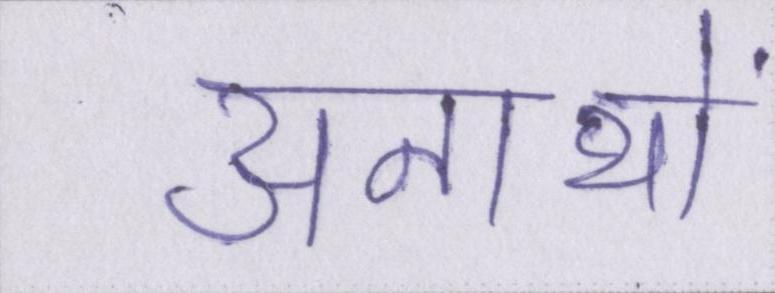


🖼 Image: HindiSeg/test/9/2/22.jpg
✅ Ground Truth: अनाथों
🔮 Prediction  : अनाओ
--------------------------------------------------


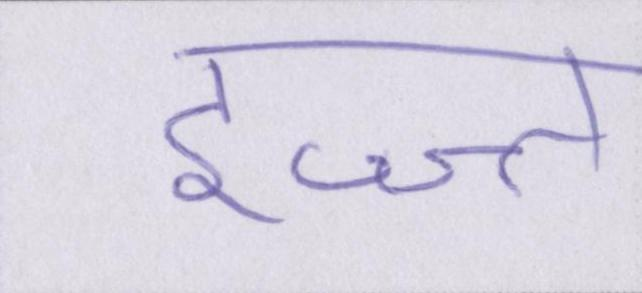


🖼 Image: HindiSeg/test/11/2/24.jpg
✅ Ground Truth: इज्ज्त
🔮 Prediction  : इजञ
--------------------------------------------------


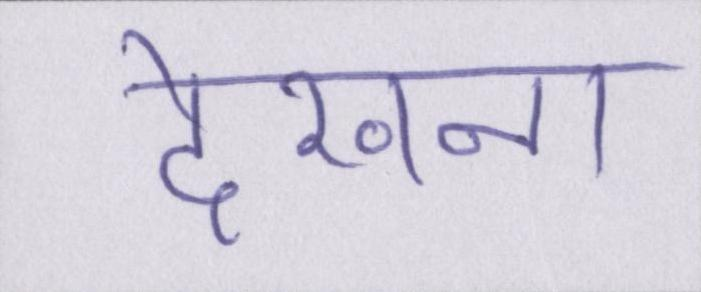


🖼 Image: HindiSeg/test/11/55/29.jpg
✅ Ground Truth: देखना
🔮 Prediction  : दखना
--------------------------------------------------


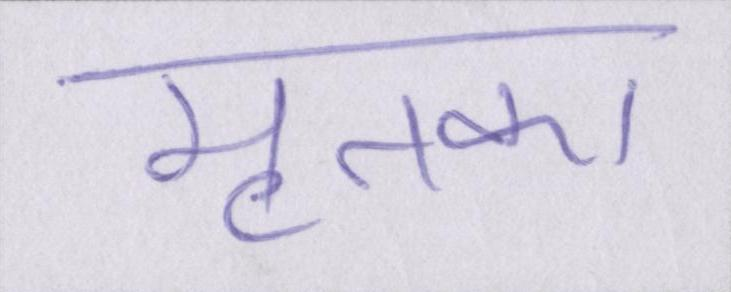


🖼 Image: HindiSeg/test/11/23/7.jpg
✅ Ground Truth: मृतका
🔮 Prediction  : मनका ।
--------------------------------------------------


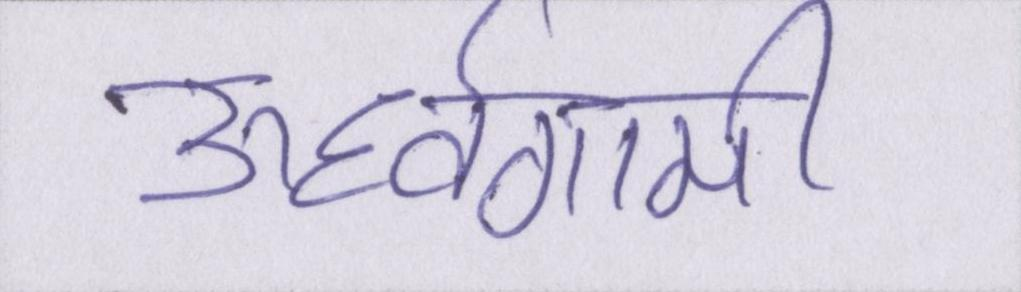


🖼 Image: HindiSeg/test/6/59/9.jpg
✅ Ground Truth: ऊर्ध्वगामी
🔮 Prediction  : अरदशी
--------------------------------------------------


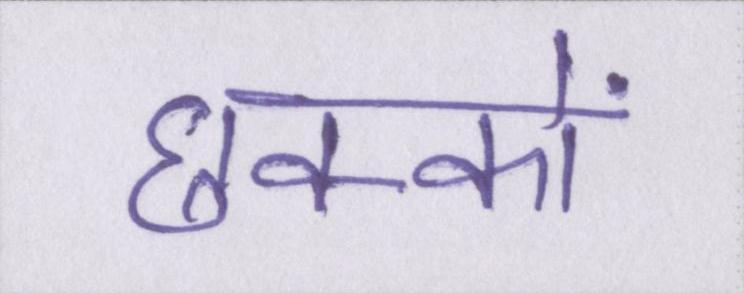


🖼 Image: HindiSeg/test/9/88/34.jpg
✅ Ground Truth: छक्कों
🔮 Prediction  : धकको
--------------------------------------------------


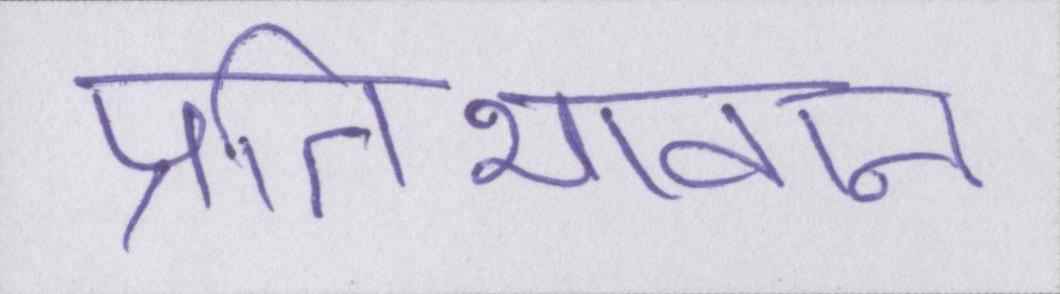


🖼 Image: HindiSeg/test/6/11/28.jpg
✅ Ground Truth: प्रतिभावान
🔮 Prediction  : परतिभावान
--------------------------------------------------


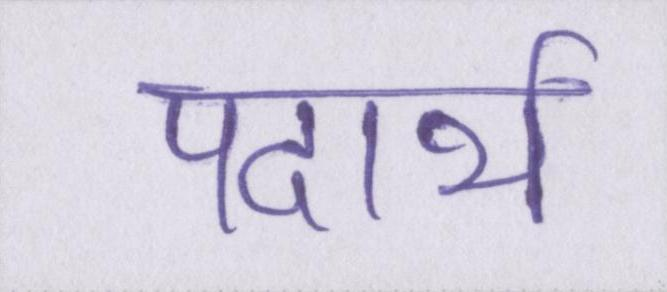


🖼 Image: HindiSeg/test/9/95/15.jpg
✅ Ground Truth: पदार्थ
🔮 Prediction  : परारथ
--------------------------------------------------


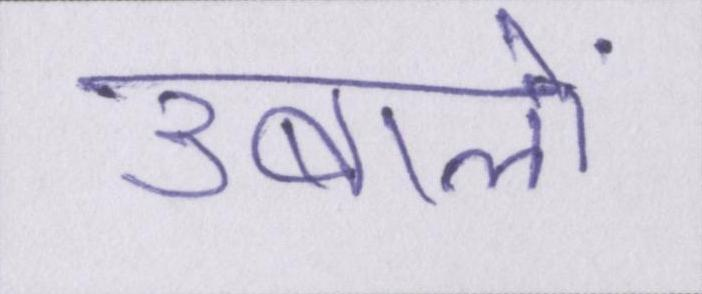


🖼 Image: HindiSeg/test/6/36/30.jpg
✅ Ground Truth: उबालें
🔮 Prediction  : उबालो
--------------------------------------------------


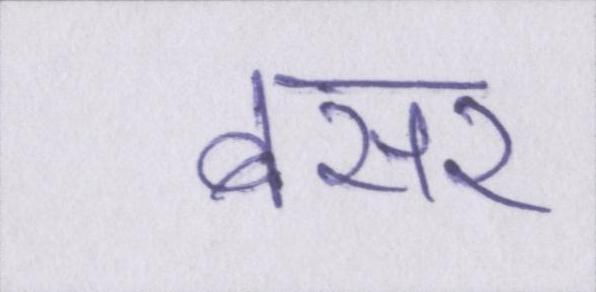


🖼 Image: HindiSeg/test/9/140/36.jpg
✅ Ground Truth: बसर
🔮 Prediction  : वसर
--------------------------------------------------


In [30]:
import torch
from PIL import Image
from IPython.display import display

# Put model in eval mode and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Number of test samples to display
num_samples = 10  # Change as needed

for idx in range(num_samples):
    # Get the test sample
    row = test_df.iloc[idx]
    image_path = root_directory + row['file_name']
    ground_truth = row['text']

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    display(image)  # Show the image

    processed_image = IAMDataset.preprocess_image(None, image)
    pixel_values = processor(processed_image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=32, num_beams=4)

    # Decode the prediction
    prediction = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    prediction = prediction.replace("##", "").strip()

    # Print the results
    print(f"\n🖼 Image: {row['file_name']}")
    print(f"✅ Ground Truth: {ground_truth}")
    print(f"🔮 Prediction  : {prediction}\n{'-'*50}")